# Task 3: Credit Risk Analysis

This project is concerned with building a model that can be used to estimate the probability of default for a borrower which can then be used to estimate the expected loss.

Expected Loss (EL)=Probability of Default (PD)×Loss Given Default (LGD)×Exposure at Default (EAD)

## Data Overview

In [4]:
#Importing important libaries
import pandas as pd
import numpy as np

In [5]:
# Reading dataset
loan_data = pd.read_csv("Loan_Data.csv")

In [6]:
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [7]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [8]:
loan_data.customer_id = loan_data.customer_id.astype(str)

In [9]:
# Unbalanced outcome variable
loan_data.default.value_counts()

default
0    8149
1    1851
Name: count, dtype: int64

## Logisitic Regression:

In [11]:
# Importing necessary libraries 
from sklearn.model_selection import train_test_split, GridSearchCV # For splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression   # For logistic regression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score # For model evaluation
from sklearn.preprocessing import StandardScaler

Assumptions in Logisitic regression which need to be verified:

1. Binary Dependent Variable
2. Independence of Observations
3. large enough sample size: at least 10 samples per feature for the smallest class in the outcome variable
4. no influential outliers can be visuialised or found using zscore
5. features must be linearly related to the logit of the outcome
6. perfect multicollinearity 

In [13]:
# target feature must be binary
loan_data.default.unique()

array([0, 1], dtype=int64)

In [14]:
#check for independent osbervations
loan_data.duplicated().sum()

0

In [15]:
# Number of features in the model
n_features = loan_data.drop(columns=['default']).shape[1]

# Minimum number of samples in the smallest class
min_samples = loan_data['default'].value_counts().min()

# Check if the minimum number of samples per class is sufficient
min_samples_per_feature = min_samples / n_features
print(min_samples_per_feature >= 10)


True


In [20]:
# from scipy.stats import zscore

# # Calculate Z-scores for the features
# loan_data_zscores = loan_data.apply(zscore)

# # Check for potential outliers
# outliers = (loan_data_zscores > 3).sum()
# print(outliers)

# # Visualizing outliers for a specific feature
# sns.scatterplot(x=loan_data.index, y=loan_data['default'])


In [40]:
# Count the number of defaulters and non-defaulters
default_count = loan_data['default'].value_counts()

# Find the minority class count (number of defaulters)
minority_count = default_count.min()

# Separate the majority and minority classes
non_defaulters = loan_data[loan_data['default'] == 0]
defaulters = loan_data[loan_data['default'] == 1]

# Randomly sample from the majority class to match the minority class count
non_defaulters_balanced = non_defaulters.sample(minority_count, random_state=42)

# Combine the balanced non-defaulters with the defaulters
loan_data_balanced = pd.concat([non_defaulters_balanced, defaulters])

# Shuffle the data to mix the rows
loan_data_balanced = loan_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


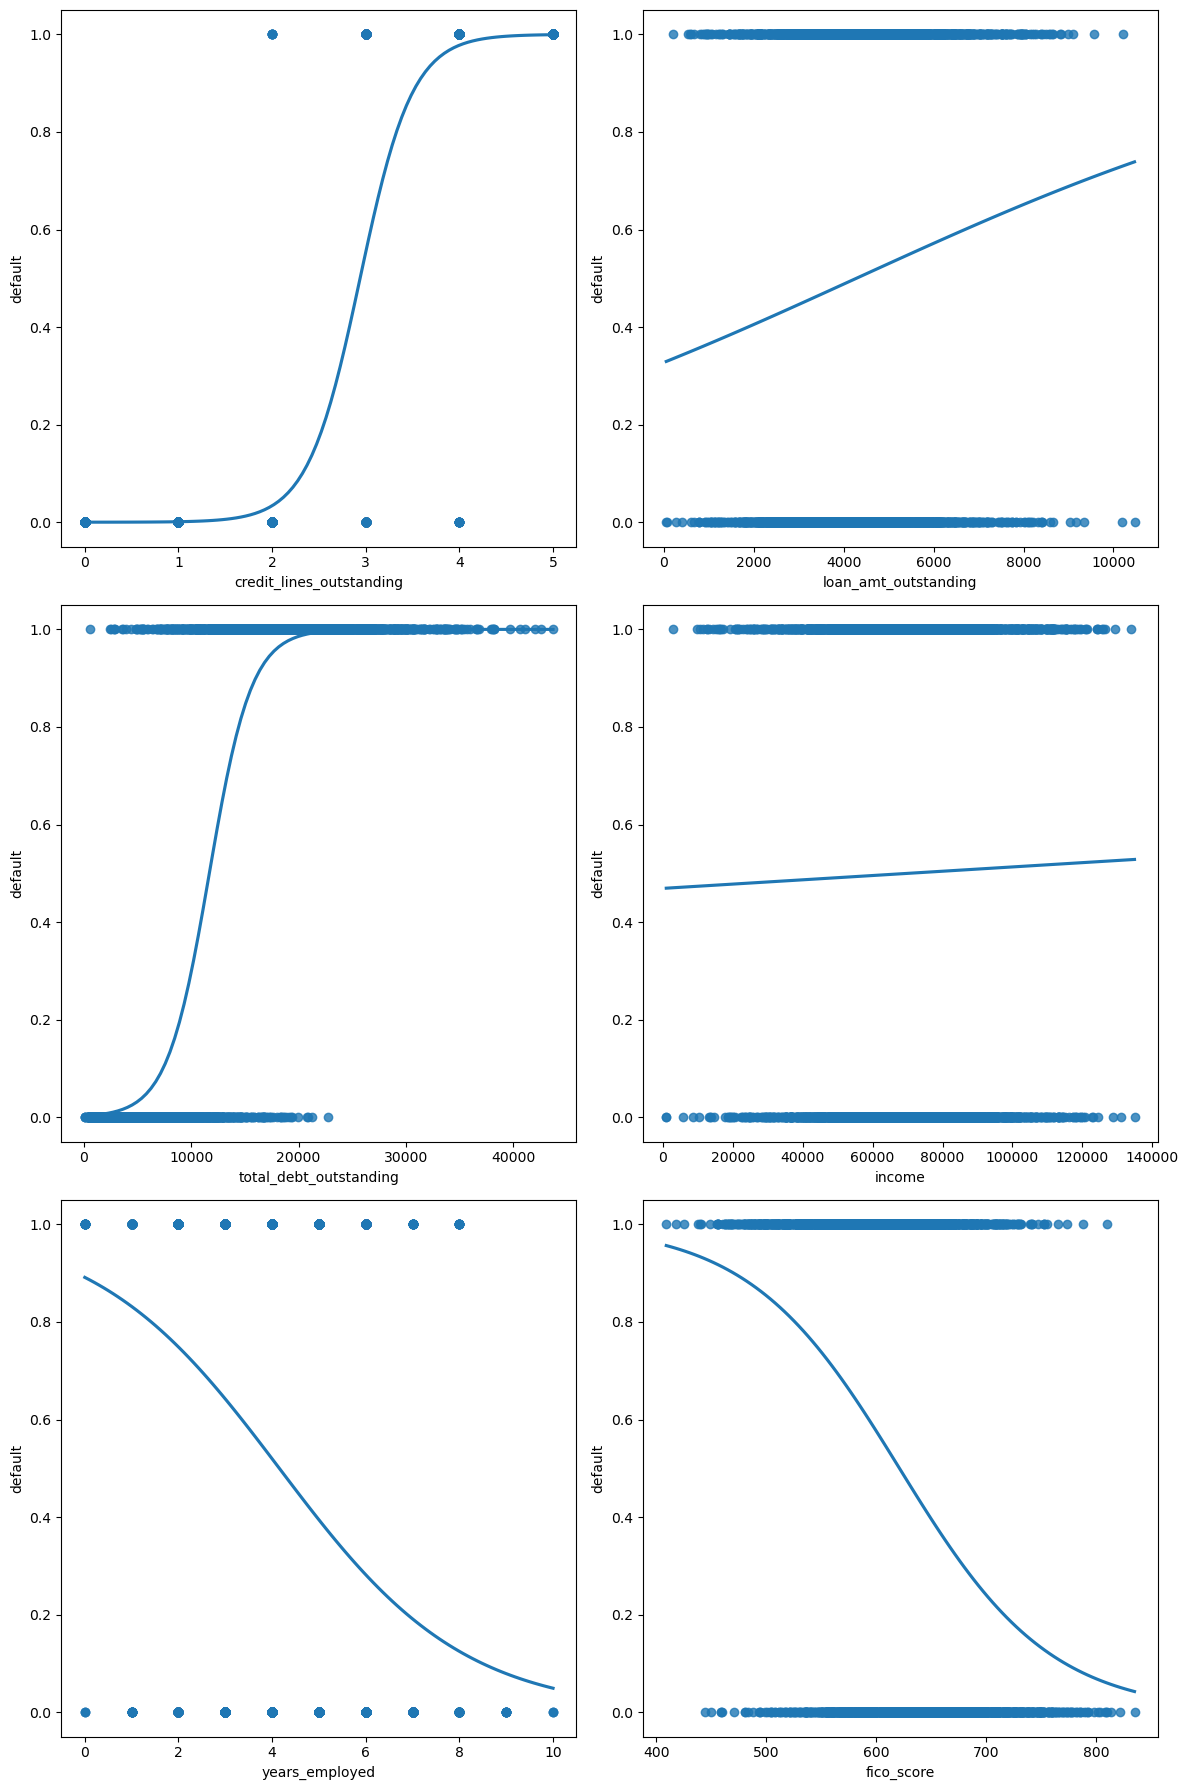

In [42]:
#checking that the features are linearly related to the logit of the outcome
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic regression plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))

sns.regplot(x='credit_lines_outstanding', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[0, 0])
sns.regplot(x='loan_amt_outstanding', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[0, 1])
sns.regplot(x='total_debt_outstanding', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[1, 0])
sns.regplot(x='income', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[1, 1])
sns.regplot(x='years_employed', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[2, 0])
sns.regplot(x='fico_score', y='default', data=loan_data_balanced, logistic=True, ci=None, ax=axes[2, 1])

plt.tight_layout()
plt.show()




Based on the above graph, it appears that income and loan amount outstanding have no significant effect on the outcome (at least in a linear sense), making them unsuitable predictors for the logistic regression model. However, for models such as random forests they may be more suitable.

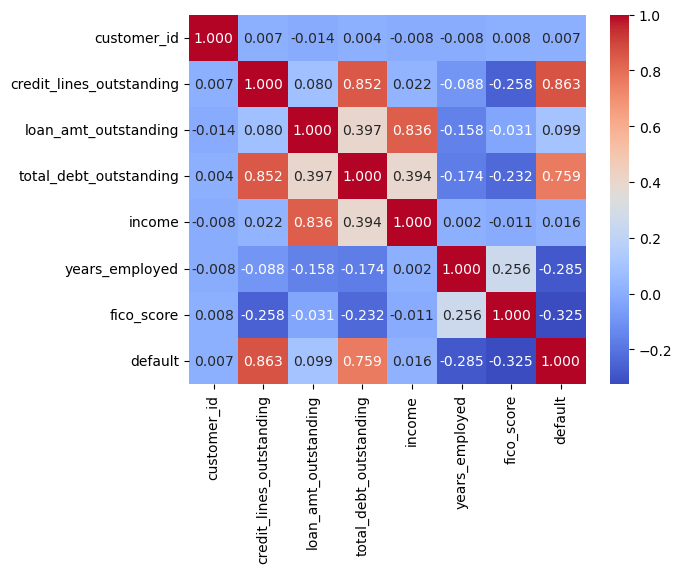

In [45]:
# checking for perfect multicollienarity
# Assuming you have already calculated the correlation matrix
corr_matrix = loan_data.corr()

# Create the heatmap with rounded values
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")

# Display the plot
plt.show()

- Credit lines outstanding and total debt outstanding show a strong relationship with the default outcome.
- Income and loan amount outstanding exhibit a weak relationship with default.
- Credit lines outstanding has a strong association with default.
- Loan amount outstanding also shows a relatively stronger relationship with default.

In [ ]:
loan_data.columns

In [ ]:
loan_data.default.value_counts()

important to set class_weights to balanced: Class imbalance occurs when the classes in a binary classification problem are not evenly distributed. This can bias models toward predicting the majority class, especially when the positive class is very rare (e.g., <1%). class_weight='balanced' adjusts weights inversely to class frequencies, giving more importance to the minority class. This can improve the model's performance on the minority class without necessarily improving overall accuracy.

In [50]:
# Define the list of feature columns to use in the model
features = [
    'credit_lines_outstanding',
    'total_debt_outstanding',
    'years_employed',
    'fico_score'
]

# Extract the feature columns from the dataset
X = loan_data[features]

# Extract the target variable (outcome) from the dataset
y = loan_data["default"]

# Split the data into training and testing sets
# 80% of the data is used for training and 20% for testing
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data to have a mean of 0 and a standard deviation of 1
# StandardScaler is used to scale the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
# This ensures that the test data is scaled in the same way as the training data
X_test = scaler.transform(X_test)


In [52]:
# Initialize the logistic regression model
log_reg = LogisticRegression(solver='liblinear', class_weight="balanced" )

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # l1 for Lasso, l2 for Ridge
}


In [54]:
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [56]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)

# Print accuracy and other metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Hyperparameters: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.994
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.98      0.99      0.98       348

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
[[1644    8]
 [   4  344]]


In [62]:
log_reg = LogisticRegression(solver='liblinear', class_weight="balanced", C = 100, penalty = "l1")
log_reg.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [64]:
probabilities = log_reg.predict_proba(X_test)

In [ ]:
probabilities * 100

In [67]:
loan_data

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


# Building expected loss function

In [105]:
def expected_loss_calc(model, loan_data, scaler, recovery_rate=0.1):
    
    """
    Calculate the expected loss for each loan in a DataFrame and add it as a new column.

    Parameters:
    - model: Trained model used for prediction
    - loan_data: DataFrame containing borrower features and loan amounts
    - scaler: Scaler used to standardize features
    - recovery_rate: Proportion of loan value recovered in case of default (default is 0.1)

    Returns:
    - loan_data: DataFrame with an additional column 'expected_loss'
    """
    # Define feature columns
    features = [
        'credit_lines_outstanding',
        'total_debt_outstanding',
        'years_employed',
        'fico_score'
    ]
    
    # Extract features from loan_data
    X = loan_data[features]
    
    # Extract loan amounts (exposure at default)
    exposure_at_default = loan_data["loan_amt_outstanding"]  # Assuming 'loan_amount' is a column with the loan amounts

    # Preprocess the data
    X_scaled = scaler.transform(X)
    
    # Predict the probability of default
    pd_prob = log_reg.predict_proba(X_scaled)[:, 1]
    
    # Calculate expected loss
    loss_given_default = 1 - recovery_rate
    expected_loss = pd_prob * loss_given_default * exposure_at_default

    # Add expected loss to the DataFrame
    loan_data['expected_loss'] = expected_loss

    return loan_data


In [107]:
# Example loan_data DataFrame
loan_data_df = pd.DataFrame({
    'credit_lines_outstanding': [15000, 20000, 12000],
    'total_debt_outstanding': [20000, 25000, 18000],
    'years_employed': [5, 3, 10],
    'fico_score': [700, 650, 720],
    'loan_amt_outstanding': [10000, 15000, 8000]  # Loan amount or exposure at default
})

# Calculate expected loss using the trained model and the scaler
result_df = expected_loss_calc(log_reg, loan_data_df, scaler)

# Display the updated DataFrame with the 'expected_loss' column
result_df


,credit_lines_outstanding,total_debt_outstanding,years_employed,fico_score,loan_amt_outstanding,expected_loss
0,15000,20000,5,700,10000,9000.0
1,20000,25000,3,650,15000,13500.0
2,12000,18000,10,720,8000,7200.0
